In [1]:
from typing import List, Dict, Any
import pandas as pd
from src.utils.methods import ConformanceMetrics

conformance_metrics: List[tuple[int, ConformanceMetrics | None, tuple[str, str]]] = []

DATA_PATH: str = "/Users/christianimenkamp/Documents/Data-Repository/"
SEPSIS_DATAFRAME_PATH: str = "Community/sepsis/Sepsis Cases - Event Log.feather"

SEPSIS_DATAFRAME: pd.DataFrame = pd.read_feather(DATA_PATH + SEPSIS_DATAFRAME_PATH)

# pm4py event log stats


def on_full_completeness(window: List[Dict[str, Any]], window_counter: int) -> None:
    e_1 = window[0]["concept:name"]
    e_2 = window[-1]["concept:name"]
    conformance_metrics.append((len(window), None, (e_1, e_2)))


START_AT, STOP_AT = (0, 500)

from src.estimator_accumulative import WindowEstimator

window = WindowEstimator(
    on_full_completeness=on_full_completeness
)

for i, row in SEPSIS_DATAFRAME.iterrows():
    window.add_event(row.to_dict())

    if START_AT < i <= STOP_AT:
        window.get_metrics(DEBUG=False)

    if i == STOP_AT + 1:
        break

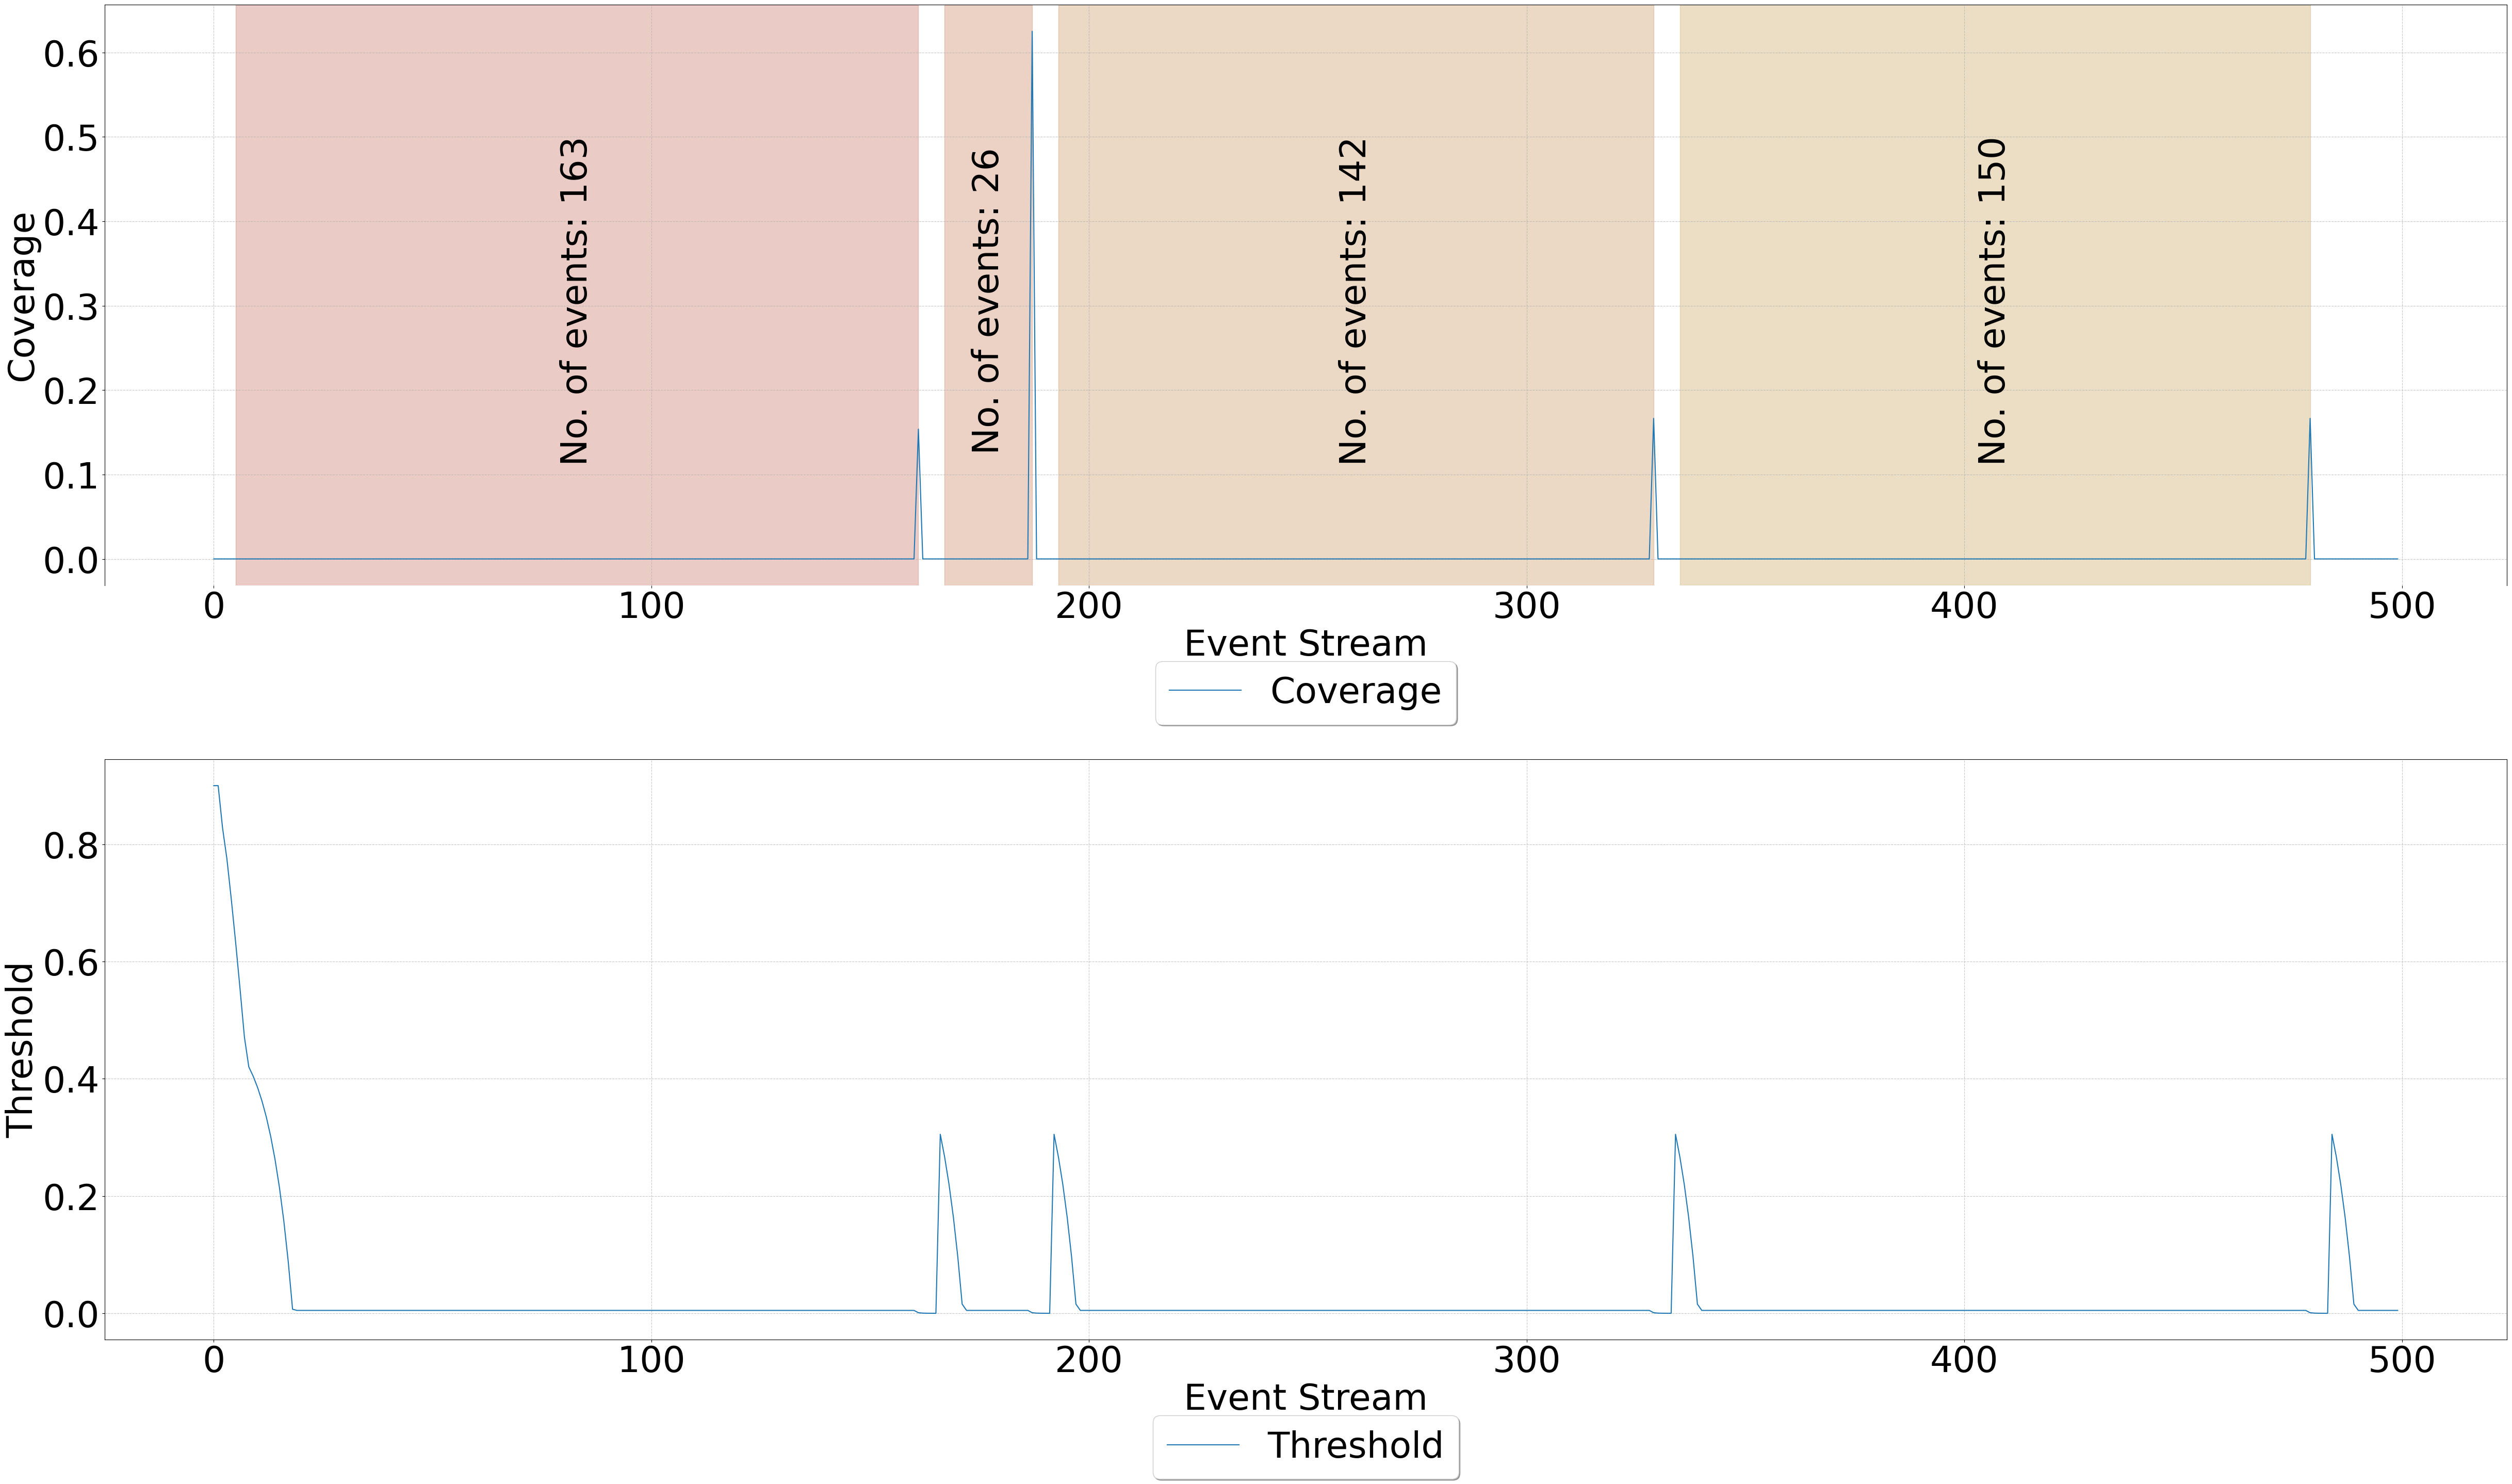

In [2]:
from src.utils.methods import ConformanceMetrics, find_non_zero_ranges
from src.utils.plotter import Plotter
from typing import List

x_axis_range: List[int] = list(range(START_AT, STOP_AT))
plotter = Plotter(x_axis_range)

full_completeness: list[int] = [y[1] for y in window.completeness_cache]

plotter.add_subplot(
    [
        (f"Coverage", full_completeness),
    ],
    y_label="Coverage",
)


for i, block in enumerate(find_non_zero_ranges(full_completeness)):
    try:
        block_fit: tuple[int, ConformanceMetrics, tuple[str, str]] = conformance_metrics[i]
        plotter.shade_regions(
            block[0],
            block[1],
            alpha=0.3,
            text=f"No. of events: {block_fit[0]} {''}",
            position="middle",
            orientation="vertical",
        )
    except IndexError:
        pass

plotter.add_subplot(
    [
        (f"Threshold", window.threshold_cache),
    ],
    include_extras=False,
    y_label="Threshold",
)

plotter.plot(50, 15, x_label="Event Stream", font_size=50)
